<!-- # Sinkhorn Algorithm for Optimal Transport

The idea of optimal transport is to find a transportation plan $\pi$ from two probability
measures $\mu$ and $\nu$ defined on the spaces $X$ and $Y$ respectively.
This transportation plan should be the most economical one.
To express that is math, we define the cost function $c$
(in discrete case it is just a matrix). This way the cost of transporting the mass
from a point $x \in X$ to $y \in Y$ has the cost $c(x, y)$.

There are several formulations of the Optimal Transport problem.

The **Kantorovich formulation** is stated as
$$
\min_{\pi \in \Pi(\mu, \nu)} \int_{X \times Y} c(x, y) d \pi (x, y),
$$
subject to the marginal constraints for all measurable sets $A \subset X$ and $B \subset Y$
$$
\pi (A \times Y) = \mu(A)
\qquad \text{and} \qquad
\pi (X \times B) = \nu(B).
$$

Computationally, it may be hard to work with this Kantorovich formulation
as it underlines a strict bounds for the problem to solve.
We may need to introduce so called _entropic regularization_ of the _Kantorovich formulation_:

$$
\min_{\pi \in \Pi(\mu, \nu)} \int_{X \times Y} c(x, y) d \pi (x, y) + \varepsilon KL(\pi | \mu \otimes \nu),
$$

where $KL(\pi)$ is the Kullback-Leibler divergence defined as
$$
KL(\pi) = \int_{X \times Y} \left( \pi \ln \left( \pi - 1 \right) \right) d\mu \otimes \nu.
$$

This regularized problem has a unique solution $\pi^*$ such that
$$
\pi^* (x, y) = u(x) \; K(x, y) \; v(y),
$$
where $K(x, y) = \exp \left\{ - c(x, y) / \varepsilon \right\} $.

For the discrete case we have
$$
\pi^* = \text{diag}(u) \; K \; \text{diag}(v)
$$
where matrix $K$ is
$$
K_{ij} = \exp \left\{ \frac{- C_{ij}}{\varepsilon} \right\}.
$$

For such vectors $u$ and $v$ we have the marginal constrains to be held
$$
\pi^* \mathbb{1} = \mu \qquad \text{and} \qquad \pi^{*T} \mathbb{1} = \nu. 
$$

These constraints lead to the iterative updates, which define the Sinkhorn Algorithm
of iteratively updating the functions $u$ and $v$ until the convergence
$$
u := \frac{\mu}{K v}, \qquad v := \frac{\nu}{K^T u}.
$$ -->

# Sinkhorn Algorithm for Optimal Transport

Optimal transport aims to find a transportation plan $\,\pi\,$ between two probability measures $\,\mu\,$ on a space $X$ and $\,\nu\,$ on a space $Y,$ minimizing a transportation cost. This cost is defined by a function $c(x,y)$ that measures how expensive it is to move a unit of mass from $x \in X$ to $y \in Y.$ 

In the **Kantorovich formulation**, one seeks
$$
\min_{\pi \in \Pi(\mu, \nu)} \int_{X \times Y} c(x, y) \,d\pi (x, y),
$$
subject to marginal constraints for all measurable sets $A \subset X$ and $B \subset Y$:
$$
\pi(A \times Y) = \mu(A), 
\quad
\pi(X \times B) = \nu(B).
$$

To make the problem more tractable, we introduce an **entropic regularization** term (Cuturi, 2013):
$$
\min_{\pi \in \Pi(\mu, \nu)} \int_{X \times Y} c(x, y) \,d \pi (x, y) 
\;+\; \varepsilon\,KL\bigl(\pi \,\bigm\|\, \mu \otimes \nu\bigr),
$$
where $KL(\pi \,\|\,\mu \otimes \nu)$ is the Kullback-Leibler divergence, typically written as
$$
KL\bigl(\pi \,\|\, \mu \otimes \nu\bigr) 
\;=\; \int_{X \times Y} \pi(x,y)\,\ln\!\biggl(\frac{\pi(x,y)}{\mu(x)\,\nu(y)}\biggr)\,d(x,y).
$$
The unique solution to this regularized problem has the form
$$
\pi^*(x,y) \;=\; u(x)\,K(x,y)\,v(y),
\quad
\text{where}
\quad 
K(x,y) \;=\; \exp\!\Bigl\{-\tfrac{c(x,y)}{\varepsilon}\Bigr\}.
$$

---

## From Continuous to Discrete

In the **continuous** setting, $X$ and $Y$ are general spaces, and $\,\mu\,$ and $\,\nu\,$ are probability measures on these spaces. The transportation plan $\,\pi\,$ is then a measure on $X \times Y,$ and the integral 
$$
\int_{X \times Y} c(x,y)\,d\pi(x,y)
$$
captures the total cost of moving mass according to $\,\pi.$

**Transition to the discrete case** arises when $X$ and $Y$ are finite sets (or discretizations of larger spaces). In that scenario:

- We replace the measures $\mu$ and $\nu$ by probability **vectors** in $\mathbb{R}^n$ and $\mathbb{R}^m,$ respectively.
- The cost function $c(x,y)$ becomes a **cost matrix** $C \in \mathbb{R}^{n \times m}$ with entries $C_{ij} = c(x_i,y_j).$
- The transportation plan $\pi$ becomes a **matrix** in $\mathbb{R}^{n \times m}$ (still a joint probability distribution).

The entropic regularized plan $\,\pi^*\,$ in the discrete case takes the form:
$$
\pi^* \;=\; \mathrm{diag}(u)\;K\;\mathrm{diag}(v),
\quad
\text{where}
\quad
K_{ij} \;=\; \exp\!\Bigl\{-\tfrac{C_{ij}}{\varepsilon}\Bigr\}.
$$
The vectors $u$ and $v$ must satisfy the marginal constraints 
$$
\pi^*\;\mathbf{1} \;=\; \mu,
\qquad
\pi^{*\!T}\;\mathbf{1} \;=\; \nu,
$$
where $\mathbf{1}$ is the all-ones vector. Solving these constraints leads directly to the **Sinkhorn algorithm**, in which $u$ and $v$ are updated iteratively:
$$
u \;:=\; \frac{\mu}{K\,v},
\qquad
v \;:=\; \frac{\nu}{K^T\,u}.
$$
Repeating these updates converges to the optimal $u$ and $v,$ yielding $\pi^*.$ This combination of entropic regularization and iterative scaling provides a computationally efficient approach to optimal transport in the discrete setting.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import ot
import ot.plot
import time

import sys

# sys.path.append("../../utils")
# from plotting import plot_ot_solution
sys.path.append("../..")
from utils import plotting

jax.config.update("jax_enable_x64", True)

plt.style.use("seaborn-v0_8-paper")
# plt.style.use("seaborn-v0_8")
plt.rcParams["image.cmap"] = "magma"

Let us use the basic example of finding the transport plan of moving one gaussian into another.
To remind that the pdf of a gaussian is:
$$
f(x | (\theta, \sigma^2)) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left\{ \frac{- (x - \theta)^2}{2 \sigma^2} \right\}
$$

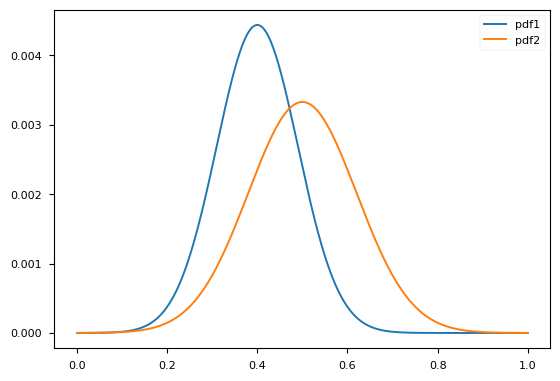

In [2]:
n = 1000
x = jnp.linspace(0, 1, n)
pdf1 = jax.scipy.stats.norm.pdf(x, loc=0.4, scale=0.09)
pdf2 = jax.scipy.stats.norm.pdf(x, loc=0.5, scale=0.12)

# better to keep these measures normalized (to be a proper pdf)
pdf1 = pdf1 / pdf1.sum()
pdf2 = pdf2 / pdf2.sum()

fig, ax = plt.subplots(1, 1)
ax.plot(x, pdf1, label="pdf1")
ax.plot(x, pdf2, label="pdf2")
ax.legend()
plt.show()

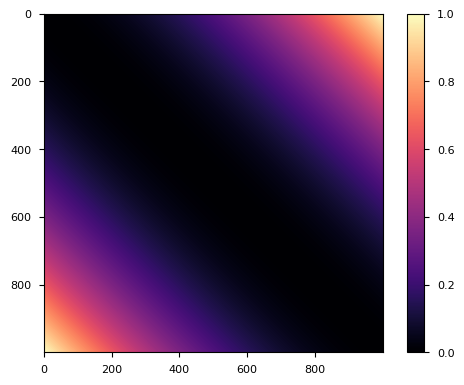

In [3]:
xx = jnp.meshgrid(x, x, indexing="ij")
cost = jnp.square(xx[0] - xx[1])

plt.imshow(cost)
plt.colorbar()
plt.show()

For the sake of numerical precision, we may want to perform all computations in the log-domain.

Firstly, the optimal transport plan in the logarithmic form is given by:
$$
\ln \pi^* (x, y) = \ln \{ u(x) \; K(x, y) \; v(y) \} = \ln u(x) + \ln K(x, y) + \ln v(y).
$$

To recover the transport plan, we simply exponentiate the entire expression:
$$
\pi^*(x, y) = \exp \left\{
    \ln u(x) + \ln K(x, y) + \ln v(y)
\right\}.
$$

This trick has a significant advantage: it allows us to use small $\varepsilon$ values
without encountering zero-division errors caused by floating-point arithmetic.

That happens due to the introduction of the term $\ln K(x, y)$, which cancels the
exponentiation operation that might otherwise lead to $-\infty$ values in the implementation.
Instead of directly working with $K(x, y)$, we simply compute:
$$
\ln K(x, y) = - \frac{C(x, y)}{\varepsilon}.
$$

Thus we must also update $u$ and $v$ in the log-domain too.
Taking logarithms of their standard updates gives:
$$
\ln u^{(n + 1)} = \ln \left\{ \frac{\mu}{K v^{(n)}} \right\} = \ln \mu - \ln \left\{ K v^{(n)} \right\},
$$
$$
\ln v^{(n + 1)} = \ln \left\{ \frac{\nu}{K^T u^{(n + 1)}} \right\} = \ln \nu - \ln \left\{ K^T u^{(n + 1)} \right\}.
$$

Note, that the terms $\ln \left\{ K v^{(n)} \right\}$ and $\ln \left\{ K^T u^{(n+1)} \right\}$
involves matrix-vector operations, which in the log-domain require **the log-sum-exp** trick:
$$
\ln u^{(n+1)}_i = \ln \mu_i - \ln \sum_{j} \exp \left\{ \ln K_{ij} + \ln v_{j}^{(n)} \right\},
$$
$$
\ln v^{(n+1)}_j = \ln \nu_j - \ln \sum_{i} \exp \left\{ \ln K^T_{ij} + \ln u_{i}^{(n+1)} \right\}.
$$

This formulation ensures numerical stability and prevents underflow when dealing
with small $\varepsilon$, making the Sinkhorn algorithm robust even in challenging conditions.

In [4]:
def sinkhorn(mu, nu, C, epsilon=0.001, niter=1000):
    ln_K = -C / epsilon
    ln_mu = jnp.log(mu)
    ln_nu = jnp.log(nu)
    ln_u = jnp.ones_like(ln_mu)
    ln_v = jnp.ones_like(ln_nu)

    def body(i, ln_uv):
        ln_u, ln_v = ln_uv
        ln_u = ln_mu - jax.scipy.special.logsumexp(ln_K + ln_v[:, None], axis=0)
        ln_v = ln_nu - jax.scipy.special.logsumexp(ln_K.T + ln_u[:, None], axis=0)
        return ln_u, ln_v

    ln_u, ln_v = jax.lax.fori_loop(0, niter, body, (ln_u, ln_v))
    return jnp.exp(ln_u[:, None] + ln_K + ln_v[None, :])

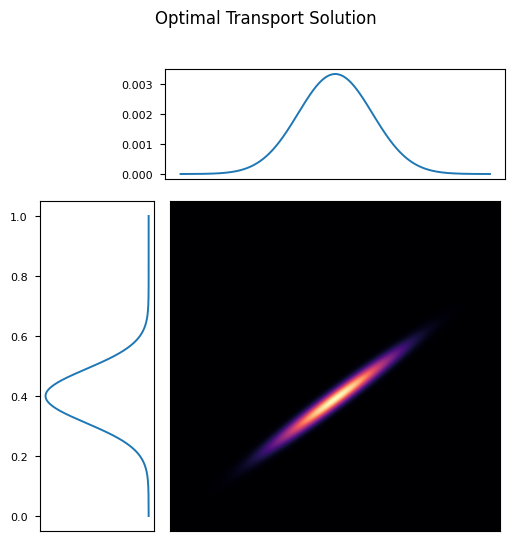

In [5]:
sol = sinkhorn(pdf1, pdf2, cost, epsilon=0.001, niter=1000)
plotting.plot_ot_solution(x, pdf1, pdf2, sol)

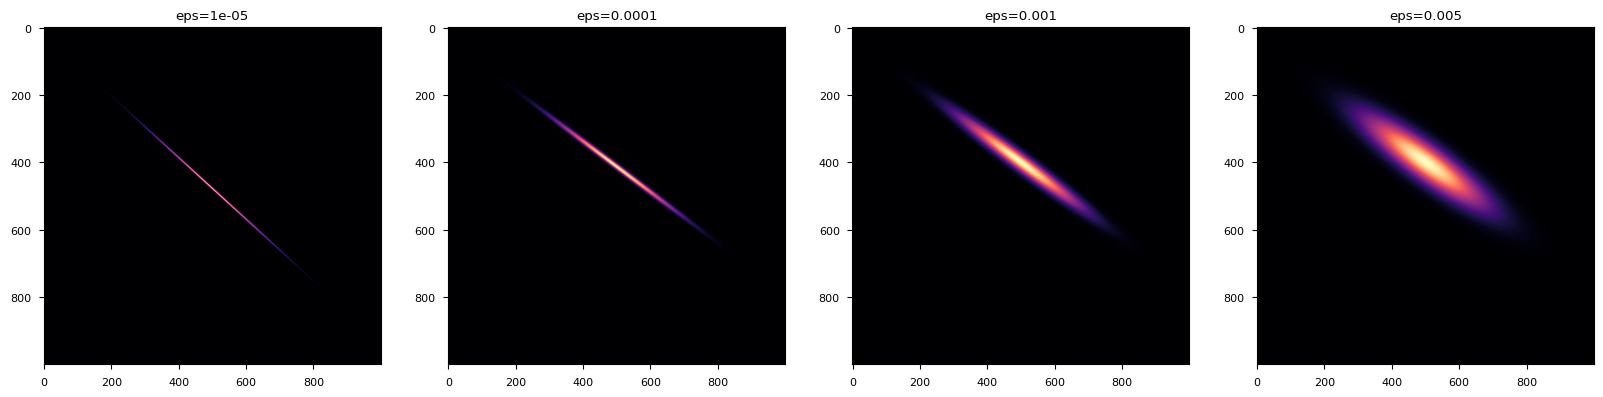

In [6]:
epss = [0.00001, 0.0001, 0.001, 0.005]
niter = 400
sols = []
for eps in epss:
    sol = sinkhorn(pdf1, pdf2, cost, epsilon=eps, niter=niter)
    sols.append(sol)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, sol in enumerate(sols):
    axs[i].imshow(sol)
    axs[i].set_title(f"eps={epss[i]}")
plt.show()

# Comparison with POT Library

Let's also compare with the implementation of POT library.

In [ ]:
def benchmark_sinkhorn(n=100, epsilon=0.01, niter=1000):
    # Define the range for x values
    x = np.linspace(0, 1, n)

    # Define two Gaussian PDFs
    pdf1 = jax.scipy.stats.norm.pdf(x, loc=0.3, scale=0.05)  # Gaussian centered at 0.3
    pdf2 = jax.scipy.stats.norm.pdf(x, loc=0.7, scale=0.08)  # Gaussian centered at 0.7

    # Normalize to ensure they sum to 1
    mu = pdf1 / pdf1.sum()
    nu = pdf2 / pdf2.sum()

    # Compute cost matrix (squared Euclidean distance)
    xx, yy = np.meshgrid(x, x, indexing="ij")
    C = jnp.square(xx - yy)

    mu_np = np.array(mu)
    nu_np = np.array(nu)
    C_np = np.array(C)

    # Run POT Sinkhorn
    start_time = time.time()
    sol_pot = ot.bregman.sinkhorn_log(mu_np, nu_np, C_np, reg=epsilon, numItermax=niter)
    # sol_pot = ot.sinkhorn(mu_np, nu_np, C_np, reg=epsilon, numItermax=niter)
    pot_time = time.time() - start_time

    # Run JAX Sinkhorn
    start_time = time.time()
    sol_jax = sinkhorn(mu, nu, C, epsilon=epsilon, niter=niter)
    jax_time = time.time() - start_time

    # Compute relative error between solutions
    relative_error = np.linalg.norm(np.array(sol_jax) - sol_pot) / np.linalg.norm(
        sol_pot
    )

    print(f"n = {n}, ε = {epsilon}, Iterations = {niter}")
    print(f"POT Sinkhorn Time: {pot_time:.4f} sec")
    print(f"JAX Sinkhorn Time: {jax_time:.4f} sec")
    print(f"Relative Error: {relative_error:.6e}")

    return pot_time, jax_time, relative_error

In [8]:
benchmark_sinkhorn(n=100, epsilon=0.001, niter=200)
benchmark_sinkhorn(n=100, epsilon=0.0001, niter=2000)
benchmark_sinkhorn(n=100, epsilon=0.00001, niter=2000)

n = 100, ε = 0.001, Iterations = 200
POT Sinkhorn Time: 0.0497 sec
JAX Sinkhorn Time: 0.3188 sec
Relative Error: 6.746823e-09
n = 100, ε = 0.0001, Iterations = 2000
POT Sinkhorn Time: 0.4274 sec
JAX Sinkhorn Time: 0.0995 sec
Relative Error: 4.172792e-08


/Users/admin/.pyenv/versions/3.10.14/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:747: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


n = 100, ε = 1e-05, Iterations = 2000
POT Sinkhorn Time: 0.5987 sec
JAX Sinkhorn Time: 0.0998 sec
Relative Error: 3.553947e-01


(0.598736047744751, 0.09977483749389648, np.float64(0.355394676959039))

In [9]:
benchmark_sinkhorn(n=100, epsilon=0.0007, niter=400)
benchmark_sinkhorn(n=1000, epsilon=0.0007, niter=400)

n = 100, ε = 0.0007, Iterations = 400
POT Sinkhorn Time: 0.1029 sec
JAX Sinkhorn Time: 0.0945 sec
Relative Error: 1.071002e-08
n = 1000, ε = 0.0007, Iterations = 400
POT Sinkhorn Time: 5.7794 sec
JAX Sinkhorn Time: 0.1062 sec
Relative Error: 2.564316e-08


(5.779357194900513, 0.10619902610778809, np.float64(2.564315789155101e-08))

<!-- As this log-sum-exp trick is also implemented in the POT library, we see that due to
the usage of `numpy` library the implementation of POT suffers from the number of operations
to perform as well as potential memory issues. That all is due to the difference between
`numpy` and `jax` libraries.

Overall, current implementation behaves better. -->

Since the log-sum-exp trick is also implemented in the POT library, we observe that due to its reliance on the NumPy library, POT's implementation suffers from a higher number of operations as well as potential memory inefficiencies. These issues arise from fundamental differences between NumPy and JAX in how they handle parallelization, lazy evaluation, and GPU acceleration.

In contrast, our current JAX-based implementation benefits from:
- Just-In-Time (JIT) compilation, which reduces redundant operations.
- Efficient GPU/TPU support, leading to faster execution for large-scale problems.
- Better memory management, as JAX optimizes computations without unnecessary array copies.

Overall, the current JAX-based Sinkhorn implementation demonstrates superior performance in both speed and memory efficiency, making it a more scalable approach for large optimal transport problems.